### Notebook that calculate the properties of annotated degrons and plots them in i) Radial plot of general features. ii) Heatmap of features per degron
- FIrst it calculate features per degron
- Then it compares it with a set of random motifs (Z-scoring each feature):
- Using a Radial Plot of the general features of degrons (Fig2a)
- Using a boxplot per feature with p-values (FigS1a)
- Using a heatmap per degron representing its features vs a set of random motifs (Fig 2b)
- Visualize the over/under representation of amino-acids in the sequence of degrrons (Fig S1b)




In [6]:
import pandas as pd
import os
import numpy as np
import re
from calculate_biochemical_properties import calculate_biochemical_properties

In [7]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### paths

In [8]:
base="../" 

uniprot = os.path.join(base,"data/uniprot_isoforms.tsv")
sequences = os.path.join(base,"data/sequences_isoforms.tsv")

path_elm_classes = os.path.join(base,"external/elm_classes_new.tsv") # 07 June 2018
path_elm_instances = os.path.join(base,"external/elm_instances_new.tsv") # 30 may 2018
path_sci_instances = os.path.join(base,"external/science_dregons_instances.csv")

path_output_classes = os.path.join(base,"data/degron_classes.tsv")
path_output_instances = os.path.join(base,"data/degron_instances.tsv")

path_simulated_protein = os.path.join(base,"data","simulated_degrons_proteins.tsv.gz")
path_simulated_random = os.path.join(base,"data","simulated_degrons.tsv.gz") 

path_properties_annotated = os.path.join(base,"data","annotated_degrons_properties.tsv")

script_features = "./pipeline_calculate_features.sh"

type_simulations = "all"

path_output_plots = os.path.join(base,"plots","Figure1")

### Load instances

In [9]:
df_annotated_instances = pd.read_csv(path_output_instances,sep="\t")

### Load simulated

In [10]:
if type_simulations == "all":
    simulated = path_simulated_random
else:
    simulated = path_simulated_protein

### First run the pipeline to calculate the features...

In [59]:
for protein in df_annotated_instances["Entry_Isoform"].unique():
    !$script_features $protein
    break # Break in case somebody run this ! remove if want to reproduce all... it may take a lot of time

Step 1. Calculating conservation score---

Step 1a. Generate MSA of input uniprot

File /home/fran/Documents/ubiquitin/code/prepare_submission//data/sequences/MSA//P14635.fa already exists! Skipping step.

Step 1b. Generate the conservation score based on MSA

File /home/fran/Documents/ubiquitin/code/prepare_submission//data/sequences/MSA//Scores/P14635.score already exists! Skipping step

Step 2. Run ANCHOR software to calculate stabilization upon binding

File /home/fran/Documents/ubiquitin/code/prepare_submission//data/features/ANCHOR/P14635-1.fa.out already exists! Skpping step

Step 3. Run SPIDER2 to calculate Solvent Accesiblity and Secondary Structure.

File /home/fran/Documents/ubiquitin/code/prepare_submission//data/features/ASA/P14635-1.spd3 already exists! Skipping step

Step 4. Run Dynamine to calculate amino-acid specific rigidity score

File /home/fran/Documents/ubiquitin/code/prepare_submission//data/features/FLEX//P14635-1._backbone.pred already exists! Skipping step

S

###  Second, Get the zscores for annotated properties and get the values of the properties 

In [11]:
df_properties_annotated = calculate_biochemical_properties(df_annotated_instances[["Entry","Entry_Isoform","START","END","DEGRON"]].drop_duplicates(),simulations=True,simulated_path=path_simulated_random,lysines=(3,20),ptms=11)

In [12]:
df_properties_annotated.drop_duplicates().shape

(180, 34)

### Save it

In [13]:
df_properties_annotated.to_csv(path_properties_annotated,sep="\t",index=False)

# Now visualize it

### ----

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
%matplotlib inline 
import seaborn as sns

### Melt the dataframe and create a row with the average of degrons

In [13]:
df_properties_annotated = pd.read_csv(path_properties_annotated,sep="\t")

In [14]:
df_properties_melted = pd.melt(df_properties_annotated,id_vars=["Entry_Isoform","DEGRON","START","END"],value_vars=["Z_ASA","Z_DSS","Z_CONS","Z_FCONS","Z_SS_C","Z_SS_H","Z_SS_E","Z_RIG","Z_ANCHOR","Z_DOMAIN","Z_FLANKING_UB_LYSINE","Z_FLANKING_LYSINE","Z_PTMS"],var_name="ZSCORE_TYPE",value_name="value")[["DEGRON","ZSCORE_TYPE","value"]].drop_duplicates()
gp_average = df_properties_annotated.groupby(["DEGRON"],as_index=False).agg({"Z_ASA":np.nanmean,"Z_DSS":np.nanmean,"Z_CONS":np.nanmean,"Z_FCONS":np.nanmean,"Z_SS_C":np.nanmean,"Z_SS_H":np.nanmean,"Z_SS_H":np.nanmean,"Z_SS_E":np.nanmean,"Z_RIG":np.nanmean,"Z_ANCHOR":np.nanmean,"Entry_Isoform":"count","Z_DOMAIN":np.nanmean,"Z_FLANKING_UB_LYSINE":np.nanmean,"Z_FLANKING_LYSINE":np.nanmean,"Z_PTMS":np.nanmean})
gp_average_melted = pd.melt(gp_average,id_vars=["Entry_Isoform","DEGRON"],value_vars=["Z_ASA","Z_DSS","Z_CONS","Z_FCONS","Z_SS_C","Z_SS_H","Z_SS_E","Z_RIG","Z_ANCHOR","Z_DOMAIN","Z_FLANKING_UB_LYSINE","Z_FLANKING_LYSINE","Z_PTMS"],var_name="ZSCORE_TYPE",value_name="value")
gp_global = gp_average_melted.groupby("ZSCORE_TYPE",as_index=False).agg({"value":"mean","Entry_Isoform":"sum"})
gp_global["DEGRON"] = "_GLOBAL_DEGRON"
gp_average_melted = pd.concat([gp_average_melted,gp_global])
gp_average_melted.reset_index(drop=True,inplace=True)

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Figure 1a (Radial Plot)

### names 

In [15]:
d_scores = {"ASA_SCORE":"S.A.","FCONS_SCORE":"FCONS","COIL":"COIL","HELIX":"HELIX","STRAND":"SHEET","DSS_SCORE":"DISORDER","RIG_SCORE":"RIGIDITY","ANCHOR_SCORE":"ANCHOR","Domain_pfam":"DOMAIN","nflanking_ub_lysines":"UB_SITES","nflanking_ptms":"PHOSPHO_SITES"}
d_zscores = {"Z_ASA":"S.A.","Z_FCONS":"FCONS","Z_SS_C":"COIL","Z_SS_H":"HELIX","Z_SS_E":"SHEET","Z_DSS":"DISORDER","Z_RIG":"RIGIDITY","Z_ANCHOR":"ANCHOR","Z_DOMAIN":"DOMAIN","Z_FLANKING_UB_LYSINE":"UB_SITES","Z_PTMS":"PHOSPHO_SITES"}

### plot of distribution of features in annotated degrons compared to random sequences

In [16]:
def get_values_sorted(order,df,degron,categories):
    values = []
    sorted_values = []
    sorted_titles = []
    for key in order:
        #print (degron,key)
        values.append(gp_average_melted[(gp_average_melted["DEGRON"]==degron)&(gp_average_melted["ZSCORE_TYPE"]==key)]["value"].values[0])
    indexes = np.array(values).argsort()[::-1][:]
    for index in indexes:
        sorted_values.append(values[index])
        sorted_titles.append(categories[index])
    return sorted_values,sorted_titles

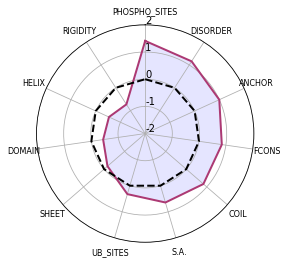

In [19]:
fig = plt.figure(figsize=(4, 4))
 
# Definition of variables 

categories=["S.A.","DISORDER","FCONS","COIL","ANCHOR","PHOSPHO_SITES","UB_SITES","HELIX","SHEET","RIGIDITY","DOMAIN"] # Labels
titles = ["Z_ASA","Z_DSS","Z_FCONS","Z_SS_C","Z_ANCHOR","Z_PTMS","Z_FLANKING_UB_LYSINE","Z_SS_H","Z_SS_E","Z_RIG","Z_DOMAIN"]
degron = "_GLOBAL_DEGRON"
    
# ------- PART 1: Create background
 

N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-2,-1,0,1,2], [-2,-1,0,1,2], color="black", size=10)
plt.ylim(-2,2)

# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values,sorted_titles=get_values_sorted(titles,gp_average_melted,degron,categories)
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Annotated Degrons",color="#ac3973")
ax.fill(angles, values, 'b', alpha=0.1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], sorted_titles,fontsize=8)

ax.plot(angles, np.zeros(12), linewidth=2, linestyle='dashed', label="Annotated Degrons",color="black")
#ax.fill(angles, np.zeros(12), 'b', alpha=0.1)

_=plt.savefig(path_output_plots+'/Figure1a_radial.pdf', bbox_inches='tight') 


# As a boxplot Fig S1a

### Plot of features-specific boxplot and significance of features

In [17]:
from scipy import stats

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/seaborn/categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


N= 180 179845


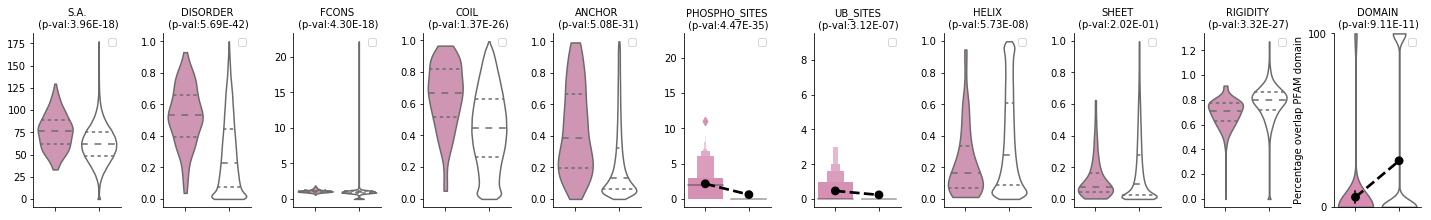

In [19]:
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams.update({'axes.titlesize': 'medium'})
fig,ax = plt.subplots(nrows=1,ncols=11)
plt.tight_layout(w_pad=1.2)
p = {"DEGRON":"#d98cb3","RANDOM":"white"}
# Define the columns of interest and dictionary of names 
# titles = ["Z_ASA","Z_DSS","Z_FCONS","Z_SS_C","Z_ANCHOR","Z_PTMS","Z_FLANKING_UB_LYSINE","Z_SS_H","Z_SS_E","Z_RIG","Z_DOMAIN"]
columns = ["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","STRAND","RIG_SCORE","Domain_pfam"]

# Prepare the dataframes
df_sim =pd.read_csv(simulated,sep="\t",compression="gzip")
df_sim = df_sim[pd.to_numeric(df_sim['RIG_SCORE'], errors='coerce').notnull()] # Temporal
df_sim["RIG_SCORE"] = df_sim.RIG_SCORE.astype(float) # TEMPORAL
df_sim=df_sim[(df_sim["FCONS_SCORE"]>=0)]  # Discard entries with weird flanking scores
df_degrons = df_properties_annotated
df_sim["Type"] = "RANDOM"
df_degrons["Type"] = "DEGRON"
df_comb = pd.concat([df_sim,df_degrons])


j = 0 
l = ["DEGRON","RANDOM"]
# Discrete values 
discrete = ["Domain_pfam","nflanking_ub_lysines","nflanking_ptms"]
i = 0
for feature in columns:

    values_other = df_sim[feature].values
    values_other = np.array(list(map(float, values_other)))
    values_motif = df_degrons[feature].values
    values_motif = np.array(list(map(float, values_motif)))
    mean_other = np.nanmean(values_other)
    mean_motif = np.nanmean(values_motif)
    mask_other = np.isfinite(values_other)
    mask_motif = np.isfinite(values_motif)
    t,pvalue = stats.mannwhitneyu(values_other[mask_other],values_motif[mask_motif])
    if feature in discrete:
        
        #sns.violinplot(data=df_comb,x="Type",y=feature,palette=p,cut=0,inner=None,saturation=0.9,scale="width",ax=ax[i][j])
        if feature == "Domain_pfam":
            sns.violinplot(data=df_comb,x="Type",y=feature,palette=p,cut=0,inner=None,saturation=1.0,scale="width",ax=ax[j],order=["DEGRON","RANDOM"])
        else:
            sns.lvplot(data=df_comb,x="Type",y=feature,palette=p,saturation=0.9,ax=ax[j],order=["DEGRON","RANDOM"])
        sns.pointplot(data=df_comb,x="Type",y=feature,estimator=np.nanmean,ci=95,order=["DEGRON","RANDOM"],linestyles="--",markers="o",errwidth=1.5,color="black",scale=1.0,ax=ax[j])
    else:
        
        sns.violinplot(x="Type",y=feature,data=df_comb,ax=ax[j],order=l,inner="quartile",split=True,palette=p,cut=0,scale="width")
    
    if mean_other > mean_motif:
        f =  - np.abs((mean_other + mean_motif)/(mean_motif))
        v = "decrease"
    else:
        f =  np.abs((mean_other + mean_motif)/(mean_other))
        v = "increase"
    ax[j].set_xlabel("")
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].set_ylabel("")
    ax[j].set_xticklabels("")
    ax[j].set_title(d_scores[feature]+"\n (p-val:{:.2E})".format(pvalue))
    
    if feature == "Domain_pfam":
        ax[j].set_ylim(0,1)
        ax[j].set_yticks([0,1])
        ax[j].set_yticklabels([0,100])
        ax[j].set_ylabel("Percentage overlap PFAM domain")
    if feature =="nflanking_lysines":
        ax[j].set_ylim(0,20)
        ax[j].set_yticks(range(0,22,2))
        
    handles, labels = ax[j].get_legend_handles_labels()
    ax[j].legend(handles[:0], labels[:0])

    if j == 10:
        i = i +1
    j = j +1
    j = j % 11
print ("N=",len(values_motif),len(values_other))
plt.savefig(path_output_plots+"/FigureS1a_boxplots.pdf",dpi=400,bbox_inches="tight")     

# Figure 1b. Heatmap 

### Plot of degron-specific feature profile

In [22]:
names_degrons = {"CBL_APS":"CBL (APS motif)","CBL_MET":"CBL (MET motif)","CBL_PTK":"CBL (PTK motif)","DEG_APCC_DBOX_1":"APC D box","DEG_APCC_KENBOX_2":"APC KEN box",
                "DEG_APCC_TPR_1":"APC TPR motif","DEG_COP1_1": "COP1 motif","DEG_CRL4_CDT2_1":"PIP motif of DTL","DEG_Kelch_KLHL3_1":"KLHL3/KLH2 motif","DEG_Kelch_Keap1_1":"KEAP1 motif 1",
                "DEG_Kelch_Keap1_2":"KEAP1 motif 2","DEG_Kelch_actinfilin_1":"KLHL17 motif","DEG_MDM2_SWIB_1":"MDM2 motif","DEG_ODPH_VHL_1":"VHL motif","DEG_SCF_FBW7_1":"FBXW7 motif 1",
                "DEG_SCF_FBW7_2":"FBXW7 motif 2","DEG_SCF_SKP2-CKS1_1":"SKP2 Fbox motif","DEG_SCF_TRCP1_1":"BTRCP motif","DEG_SIAH_1":"SIAH motif","DEG_SPOP_SBC_1":"SPOP motif",
                "ITCH":"ITCH motif","LIG_APCC_ABBA_1":"APC ABBA motif","LIG_APCC_Cbox_1":"APC Cbox motif","SCF_FBXO31":"FBX031 motif","_GLOBAL_DEGRON":"_MEAN degron"}

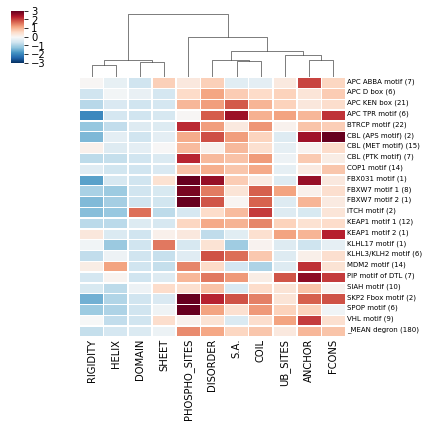

In [23]:
gp_average_melted["DEGRON_INFO"] = gp_average_melted.apply(lambda row: names_degrons[row["DEGRON"]] + " (" + str(row["Entry_Isoform"]) + ")",axis=1)
df = gp_average_melted[(gp_average_melted["ZSCORE_TYPE"]!="Z_FLANKING_LYSINE")&(gp_average_melted["ZSCORE_TYPE"]!="Z_CONS")].pivot("DEGRON_INFO","ZSCORE_TYPE","value")
g= sns.clustermap(df,vmin=-3,vmax=3,linewidths=0.5,cmap=plt.cm.RdBu_r,row_cluster=False,figsize=(6,6),method="ward")

labels_x =[d_zscores[label.get_text()] for label in  g.ax_heatmap.get_xticklabels()]



_=g.ax_heatmap.set_xticklabels(labels_x,fontsize=10)
_=g.ax_heatmap.set_yticks(range(0,len(df.index.values)))
_=g.ax_heatmap.set_yticklabels(df.index.values,fontsize=7,va="top")
g.ax_heatmap.minorticks_off()
g.ax_heatmap.tick_params(axis = 'x', labelsize =10  , pad=1.5,width=0.0, length = 0)
g.ax_heatmap.tick_params(axis = 'y', labelsize =7  , pad=1.5,width=0.0, length = 0)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("")
plt.savefig(path_output_plots+'/Figure1b_heatmap.pdf', dpi=400,bbox_inches="tight")

# Supplementary Figure S1b

### Plot of enrichment of amino acids in annotated degrons

In [24]:
from collections import defaultdict

### Calculate background of all human sequences

In [21]:
path_sequences = os.path.join(base,"data","sequences_isoforms.tsv")
df_sequences = pd.read_csv(path_sequences,sep="\t")
s={}
total = 0
for seq in df_sequences["Sequence"].unique():
    for aa in list(seq):
        if aa in s:
            s[aa]+=1
        else:
            s[aa]=1
        total = total +1 
df_numbers = pd.DataFrame(list(s.items()),columns=["AA","NUM"])
df_numbers["Ratio"] = df_numbers.apply(lambda row: row["NUM"] / total,axis=1)

### Calculate the ratios for annotated degrons

In [22]:
s = {}
total = 0
for index,row in df_annotated_instances.iterrows():
    seq = df_sequences[(df_sequences["Entry_Isoform"]==row["Entry_Isoform"])]["Sequence"].values[0]
    seq = seq[row["START"]-1:row["END"]]
    for aa in list(seq):
        if aa in s:
            s[aa]+=1
        else:
            s[aa]=1
        total = total +1 
df_numbers_degron = pd.DataFrame(list(s.items()),columns=["AA","NUM_DEGRON"])
df_numbers_degron["Ratio_Degron"] = df_numbers_degron.apply(lambda row: row["NUM_DEGRON"] / total,axis=1)

### Combine both dfs and perform statistical test

In [23]:
df_numbers_degron = pd.merge(df_numbers_degron,df_numbers[["AA","Ratio","NUM"]],how="left")
df_numbers_degron["Balance"] = df_numbers_degron.apply(lambda row: row["Ratio_Degron"] / row["Ratio"],axis=1)
l = []
for index,row in df_numbers_degron.iterrows():
    aa = row["AA"]
    a = row["NUM_DEGRON"]
    b = np.nansum(df_numbers_degron[(df_numbers_degron["AA"]!=aa)]["NUM_DEGRON"].values)
    c = row["NUM"]
    d = np.nansum(df_numbers_degron[(df_numbers_degron["AA"]!=aa)]["NUM"].values)
    odd,pvalue_fisher = stats.fisher_exact([[a,b],[c,d]],alternative="greater")
    chi2,p_value_chi2,dof,expected = stats.chi2_contingency([[a,b],[c,d]],lambda_="log-likelihood")
    l.append([aa,a,b,c,d,odd,pvalue_fisher,chi2,p_value_chi2,dof,expected])
df_stats = pd.DataFrame(l,columns=["AA","a","b","c","d","Odd_Ratio","Pvalue_Fisher","Chi2","Pvalue_Gtest","DOF","Expected"])

In [24]:
df_stats.sort_values("Pvalue_Gtest",ascending=True)

AA    a     b        c         d  Odd_Ratio  Pvalue_Fisher       Chi2  \
0   D  145  1154   876312  17318528   2.483216   2.610316e-20  83.594434   
19  C    5  1294   403133  17791707   0.170532   1.000000e+00  28.780415   
14  K   40  1259  1055079  17139761   0.516124   9.999983e-01  20.370401   
13  P  123  1176  1142668  17052172   1.560837   5.633313e-06  19.149116   
16  A   55  1244  1265800  16929040   0.591302   9.999859e-01  16.619970   
10  L   91  1208  1791762  16403078   0.689635   9.998666e-01  12.643660   
4   E  120  1179  1310295  16884545   1.311559   3.536661e-03   7.175942   
8   F   65  1234   656336  17538504   1.407552   6.055841e-03   6.186044   
15  V   58  1241  1092560  17102280   0.731585   9.935628e-01   5.651697   
12  Y   49  1250   484088  17710752   1.434164   1.091090e-02   5.143136   
17  M   17  1282   391872  17802968   0.602433   9.903545e-01   4.618644   
2   G   66  1233  1182583  17012257   0.770036   9.859342e-01   4.372843   
1   S  130  1169  1517470  16677370   1.222183   1.881407e-02   4.266060   
3   I   46  1253   798434  17396406   0.799884   9.442450e-01   2.154926   
6   Q   54  1245   871656  17323184   0.861999   8.730396e-01   1.050987   
18  R   67  1232  1024386  17170454   0.911554   7.859026e-01   0.471579   
5   N   52  1247   661319  17533521   1.105592   2.581515e-01   0.392442   
9   H   31  1268   471617  17723223   0.918746   7.034122e-01   0.146738   
11  W   14  1285   219109  17975731   0.893822   6.968632e-01   0.086641   
7   T   71  1228   978361  17216479   1.017432   4.608672e-01   0.006393   

    Pvalue_Gtest  DOF                                           Expected  
0   6.074386e-20    1  [[62.569188056872946, 1236.430811943127], [876...  
19  8.106677e-08    1  [[28.779526359960208, 1270.2204736400397], [40...  
14  6.380915e-06    1  [[75.32364865975138, 1223.6763513402486], [105...  
13  1.208935e-05    1  [[81.58244499011576, 1217.4175550098842], [114...  
16  4.566763e-05    1  [[90.36783270341033, 1208.6321672965896], [126...  
10  3.768416e-04    1  [[127.91818346738283, 1171.0818165326173], [17...  
4   7.388765e-03    1  [[93.54891633879033, 1205.4510836612096], [131...  
8   1.287617e-02    1  [[46.859660667573486, 1252.1403393324265], [65...  
15  1.743849e-02    1  [[78.00065618316061, 1220.9993438168394], [109...  
12  2.333845e-02    1  [[34.561945421498486, 1264.4380545785016], [48...  
17  3.162624e-02    1  [[27.976474075077135, 1271.0235259249228], [39...  
2   3.651601e-02    1  [[84.42785862429386, 1214.5721413757062], [118...  
1   3.888099e-02    1  [[108.33959885665854, 1190.6604011433415], [15...  
3   1.421133e-01    1  [[57.0025058612709, 1241.997494138729], [79842...  
6   3.052799e-01    1  [[62.230305560976426, 1236.7696944390236], [87...  
18  4.922617e-01    1  [[73.1344406085269, 1225.8655593914732], [1024...  
5   5.310185e-01    1  [[47.21446285940111, 1251.785537140599], [6613...  
9   7.016719e-01    1  [[33.670371060585985, 1265.329628939414], [471...  
11  7.684923e-01    1  [[15.642921665964412, 1283.3570783340356], [21...  
7   9.362731e-01    1  [[69.84905797872834, 1229.1509420212717], [978...

##### Plot it!

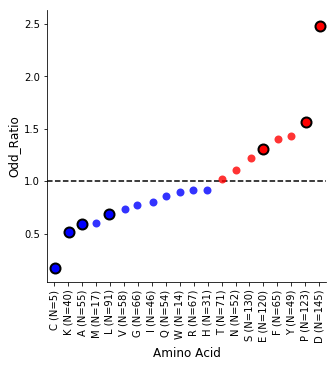

In [29]:
def plot_enrichment_aas(df_stats):
    fig,ax = plt.subplots(figsize=(5,5))
    order_aas = df_stats.sort_values("Odd_Ratio")["AA"].values
    sns.stripplot(data=df_stats[(df_stats["Odd_Ratio"]<1)&(df_stats["Pvalue_Gtest"]<0.01)],x="AA",y="Odd_Ratio",order=order_aas,color="blue",size=10,alpha=1.0,linewidth=2,edgecolor="black")
    sns.stripplot(data=df_stats[(df_stats["Odd_Ratio"]<1)&(df_stats["Pvalue_Gtest"]>=0.01)],x="AA",y="Odd_Ratio",order=order_aas,color="blue",size=8,alpha=0.8)
    sns.stripplot(data=df_stats[(df_stats["Odd_Ratio"]>=1)&(df_stats["Pvalue_Gtest"]<0.01)],x="AA",y="Odd_Ratio",order=order_aas,color="red",size=10,alpha=1.0,linewidth=2,edgecolor="black")
    sns.stripplot(data=df_stats[(df_stats["Odd_Ratio"]>=1)&(df_stats["Pvalue_Gtest"]>=0.01)],x="AA",y="Odd_Ratio",order=order_aas,color="red",size=8,alpha=0.8)
    ax.axhline(1,linestyle="--",color="black")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticklabels([ aa +" (N="+str(n)+")" for aa,n in df_stats.sort_values("Odd_Ratio")[["AA","a"]].values],fontsize=10,rotation=90)
    plt.yticks(fontsize=10, rotation=0)
    plt.ylabel("Odd_Ratio",fontsize=12)
    plt.xlabel("Amino Acid",fontsize=12)
    plt.savefig(path_output_plots+'/FigureS1b_enrichment_aas.pdf', dpi=800,bbox_inches="tight") 
    
plot_enrichment_aas(df_stats)